# MR Spectroscopy with Osprey
## Analyzing MR Spectra from Human Motor Cortex

**Author**: Michal Toth


### Citation and Resources:


#### Tools included in this workflow
__Osprey__:
- G Oeltzschner, HJ Zöllner, SCN Hui, M Mikkelsen, MG Saleh, S Tapper, RAE Edden. Osprey: Open-Source Processing, Reconstruction & Estimation of Magnetic Resonance Spectroscopy Data. J Neurosci Meth 343:108827 (2020). [https://doi.org/10.1016/j.jneumeth.2020.108827](https://doi.org/10.1016/j.jneumeth.2020.108827)
- [Osprey documentation](https://schorschinho.github.io/osprey/)

__Python__:

- Python Software Foundation. (2023). Python (Version 3.11.6) [Software]. Available at [https://www.python.org/](https://www.python.org/)

__Dataset__:
- Collected at UQ as part of the BeLong study
- T1 weighted MP2RAGE at 3T (healthy control)
- SLASER MRS at 3T (healthy control)

## Introduction
This example demonstrates the processing of MR spectra acquired from the human motor cortex using `Osprey`, a standalone tool for processing and quantification of magnetic resonance spectroscopy (MRS) data.

The example dataset is processed with Osprey to quantify metabolite concentrations.


In [ ]:
# TODO: extra reading?

### Check CPU vendor and model for compatibility or performance considerations


In [1]:
!cat /proc/cpuinfo | grep 'vendor' | uniq
!cat /proc/cpuinfo | grep 'model name' | uniq

vendor_id	: GenuineIntel
model name	: Intel(R) Core(TM) i7-14700


### Load software tools and import python libraries

In [ ]:
import module
await module.load('osprey/2.9.0')
await module.list()

In [1]:
import os
from pathlib import Path
from IPython.display import Image, display
from ipyniivue import NiiVue
import nibabel as nib
import numpy as np
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
import json
import subprocess

## Set up Osprey Job configuration

1. Set up paths to the relevant MRS/MRI files
2. Check that all specified paths exist
3. Set up the configuration JSON file

_NOTE: For a more detailed explanation of all the configuration options see [Osprey's documentation](https://schorschinho.github.io/osprey/the-osprey-job-file.html)_

In [ ]:
# Get path to Osprey executable.
lcmodel_path = subprocess.check_output("which ospreyCMD", shell=True, text=True).strip()

# Extract container base and image path.
container_base = os.path.dirname(lcmodel_path)
container_id = os.path.basename(container_base)
simg_path = os.path.join(container_base, f"{container_id}.simg")

# Construct the basis set path (from inside the container).
basis_file = os.path.join(
    simg_path,
    "/opt/basissets/3T/siemens/unedited/slaser/30/basis_siemens_slaser30.mat"
)

In [4]:
data_path = '/home/jovyan/data'
output_path = '/home/jovyan/data/MRS/osprey-output'
os.makedirs(output_path, exist_ok=True)
basis_set = 'basis.BASIS' # basis_file
job_path = '/home/jovyan/osprey/osprey-job.json'
os.makedirs('/home/jovyan/osprey', exist_ok=True)
sub = 'sub-002'
ses = 'ses-01'
# Metabolite data.
files = [
    f'{data_path}/{sub}/{ses}/mrs/meas_MID00103_FID130220_svs_slaser_dkd_ul.dat'
]
# Water reference data.
files_ref = [
    f'{data_path}/{sub}/{ses}/mrs/meas_MID00104_FID130221_svs_slaser_dkd_ul_wref.dat'
]
# T1.
files_nii = [
    f'{data_path}/{sub}/{ses}/anat/sub-002_ses-01_acq-MP2RAGE_T1w.nii'
]

In [5]:
check_paths = [data_path, output_path, basis_set, job_path]
check_paths = check_paths + files + files_ref + files_nii

# Create the results directory if it doesn't exist yet
os.makedirs(output_path, exist_ok=True)

any_warning = False
for pth in check_paths:
    pth_exists = Path(pth).exists()
    print(f"{'✅' if pth_exists else '❌'}  '{pth}'")

✅  'data'
✅  'osprey-output'
❌  'basis.BASIS'
✅  'osprey-job.json'
✅  'data/sub-002/ses-01/mrs/meas_MID00103_FID130220_svs_slaser_dkd_ul.dat'
✅  'data/sub-002/ses-01/mrs/meas_MID00104_FID130221_svs_slaser_dkd_ul_wref.dat'
✅  'data/sub-002/ses-01/anat/sub-002_ses-01_acq-MP2RAGE_T1w.nii'


In [6]:
mrs_options = {
    'seqType': 'unedited',
    'editTarget': ['none'],
    'dataScenario': 'invivo',
    'outputFolder': [output_path],
    'SpecReg': 'RobSpecReg',
    'saveLCM': '1',
    'savejMRUI': '0',
    'saveVendor': '1',
    'saveNII': '1',
    'savePDF': '0',
    'SubSpecAlignment': 'none',
    'EECmetab': '1',
    'ECCmm': '1',
    'includeMetabs': ['default'],
    'method': 'LCModel',
    'range': ['0.5', '4.2'],
    'style': 'Separate',
    'rangeWater': ['2.0', '7.4'],
    'bLineKnotSpace': '5',
    'fitMM': '1',
    'basisSet': basis_set,
    'files': files,
    'files_ref': files_ref,
    'files_nii': files_nii
}
with open(job_path, 'w') as f:
    json.dump(mrs_options, f)

## Run Osprey processing
The following command runs the Oprey CLI software with specifications from the job file defined above.

In [15]:
!ospreyCMD {job_path}

## Results

### T1s with the MRS voxel aligned
- Osprey performs co-registration
- Osprey also performs segmentation to determine the proportion of tissue types within the voxel (for WM and CSF correction)

In [17]:
# Prepare the main viewer withot the 3D render.
nv = NiiVue(
    height=600,
    multiplanar_layout="ROW",
    multiplanar_show_render=False,
    multiplanar_pad_pixels=10,
    is_ruler=False,
    is_colorbar=False,
    is_orient_cube=False,
    is_radiological_convention=False,
    back_color=(0.1,0.1,0.1,1.0),
    crosshair_color=[0,0,0,1]
)

# Robust intensity window (ignore zeros and outliers)
t1 = nib.load(files_nii[0]).get_fdata()
vals = t1[t1 > 0]
vmin, vmax = np.percentile(vals, [0.5, 99.5]) if vals.size else (None, None)

# T1 with contrast adjusted.
nv.add_volume({
    "path": files_nii[0],
    "name": "native",
    "opacity": 1.0,
    "colormap": "gray",
    "cal_min": float(vmin) if vmin is not None else None,
    "cal_max": float(vmax) if vmax is not None else None,
    "ignore_zero_voxels": True,
})

# WM segmentation.
nv.add_volume({
    "path": f'{output_path}/SegMaps/meas_MID00103_FID130220_svs_slaser_dkd_ul_space-scanner_Voxel-1_label-WM.nii.gz',
    "name": "wm",
    "opacity": 0.5,
    "colormap": "red",
    "ignore_zero_voxels": True,
})

# GM segmentation.
nv.add_volume({
    "path": f'{output_path}/SegMaps/meas_MID00103_FID130220_svs_slaser_dkd_ul_space-scanner_Voxel-1_label-GM.nii.gz',
    "name": "gm",
    "opacity": 0.5,
    "colormap": "blue",
    "ignore_zero_voxels": True,
})

# CSF segmentation.
nv.add_volume({
    "path": f'{output_path}/SegMaps/meas_MID00103_FID130220_svs_slaser_dkd_ul_space-scanner_Voxel-1_label-CSF.nii.gz',
    "name": "csf",
    "opacity": 0.5,
    "colormap": "green",
    "ignore_zero_voxels": True,
})

# Add legend (in HTML so we can style).
fontsize = 25
entry_sep = 25
text_sep = 10
cube_size = 20
capt = widgets.HTML(
    f"<div style='font:{fontsize}px sans-serif; margin-left:285px;'>"
    f"<div style='display:inline-block; margin-right:{entry_sep}px;'>"
    f"<span style='display:inline-block; width:{cube_size}px; height:{cube_size}px; background-color:#de4743; margin-right:{text_sep}px;'></span>WM"
    "</div>"
    f"<div style='display:inline-block; margin-right:{entry_sep}px;'>"
    f"<span style='display:inline-block; width:{cube_size}px; height:{cube_size}px; background-color:#4037a4; margin-right:{text_sep}px;'></span>GM"
    "</div>"
    f"<div style='display:inline-block; margin-right:{entry_sep}px;'>"
    f"<span style='display:inline-block; width:{cube_size}px; height:{cube_size}px; background-color:#479a2e; margin-right:{text_sep}px;'></span>CSF"
    "</div>"
    "</div>"
)
# Put the legend above the NiiVue viewer.
panel = widgets.VBox([capt, nv])

display(panel)

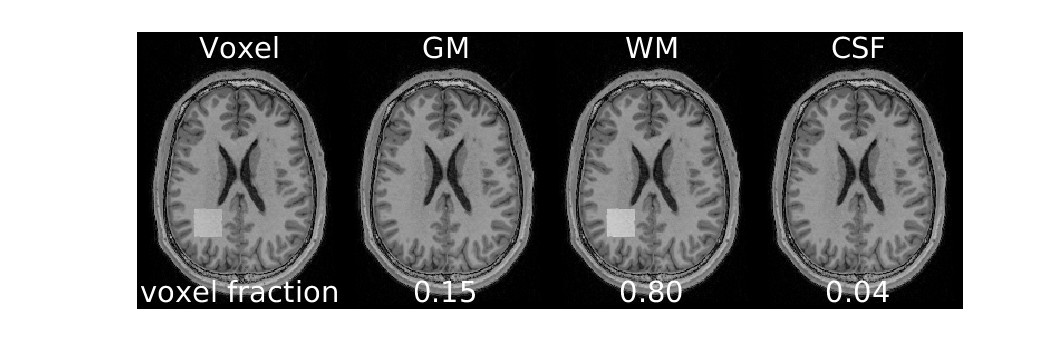

In [25]:
display(Image(filename=f"{output_path}/Reports/reportFigures/sub-002/sub-002_seg_svs_space-scanner_mask.jpg"))

### Spectral modelling
- Osprey runs LCModel for spectral fitting

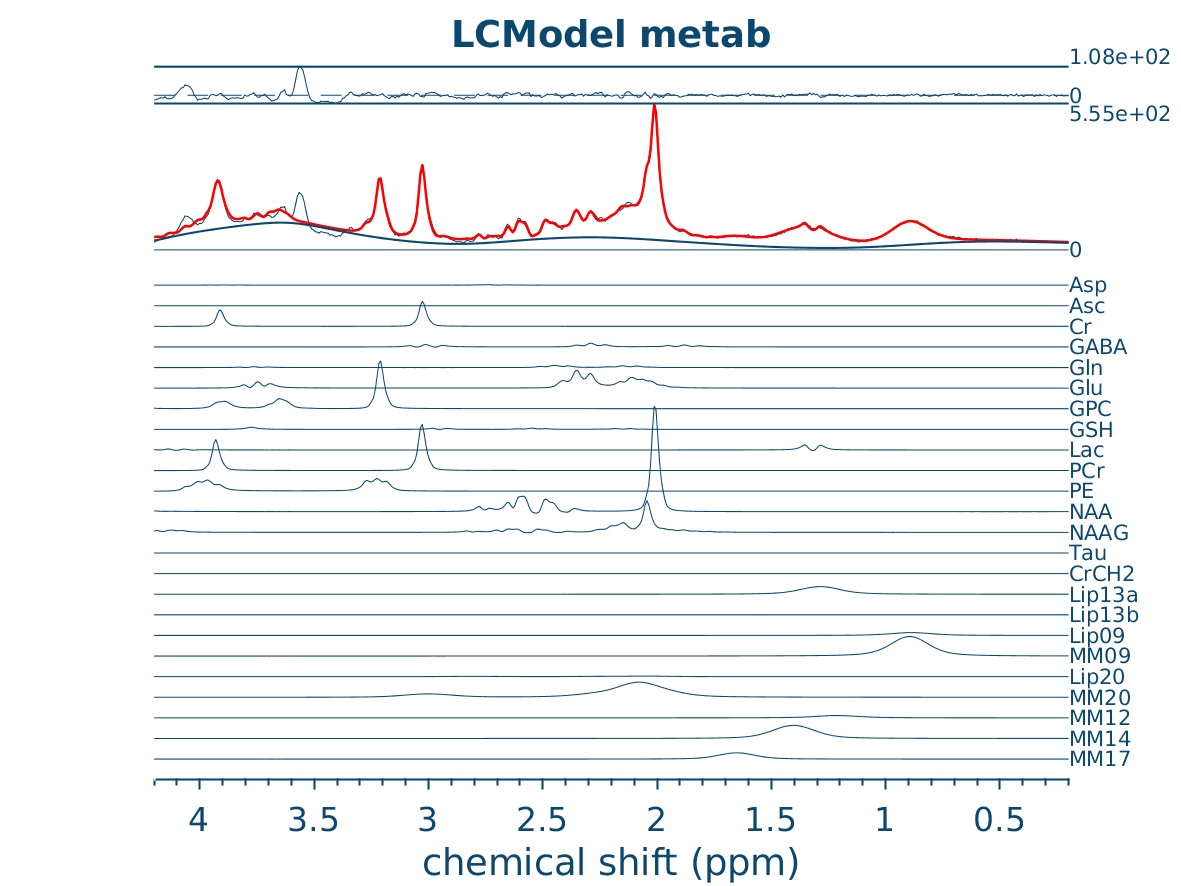

In [33]:
display(Image(filename=f"{output_path}/Reports/reportFigures/sub-001/sub-001_metab_A_model.jpg"))

In [8]:
# HTML-formatted title so that it can be combined with an image.
title = widgets.HTML(
    f"""
    <div style='
        font:25px sans-serif;
        text-align:center;
        color:black;
        background-color:white;
        padding:10px;
        display:block;
        width:100%;
        box-sizing:border-box;
    '>
        Averaged spectra
    </div>
    """
)

img = widgets.Image.from_file(f"{output_path}/Reports/reportFigures/sub-002/sub-002_metab_A.jpg")

# Put the title above the image.
panel = widgets.VBox([title, img], layout=widgets.Layout(width="50%"))
display(panel)

### Metabolite concetrations
- Osprey calculates metabolite concentrations relative to different references

In [12]:
metabolites = ['Cr', 'GABA', 'Gln', 'Glu', 'GPC', 'GSH', 'Lac', 'PCr', 'PE', 'NAA', 'NAAG', 'Tau', 'CrCH2', 'tCr', 'tNAA', 'Glx']

def plot_metabolites(data, figsize=(20, 5), label='(raw values in arbitrary units)', ytick_step=0.2):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()
    ax.bar(height=data.values[0], x=data.columns, zorder=2)
    ax.set_title(f'Metabolites\n{label}')
    
    ylims = ax.get_ylim()
    yticks = np.arange(ylims[0], ylims[1], ytick_step)
    ax.set_yticks(yticks)
    
    ax.grid(axis='y', zorder=1)

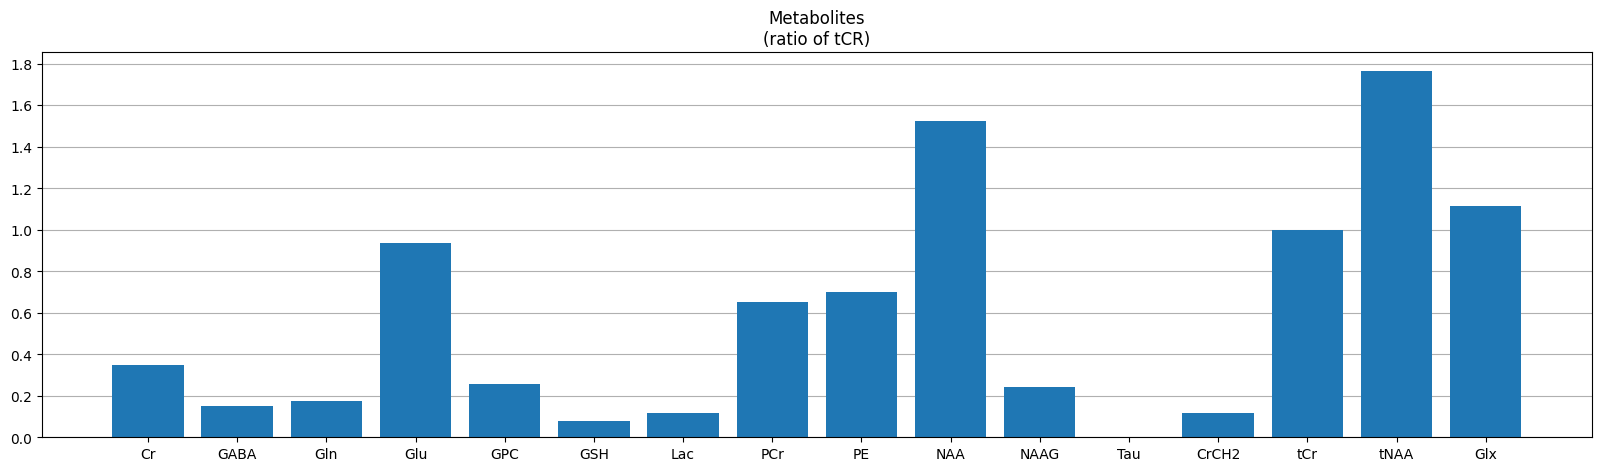

In [15]:
met_data = pd.read_csv(f'{output_path}/QuantifyResults/A_tCr_Voxel_1_Basis_1.tsv', delimiter='\t')
plot_metabolites(met_data[metabolites], label='(ratio of tCR)')

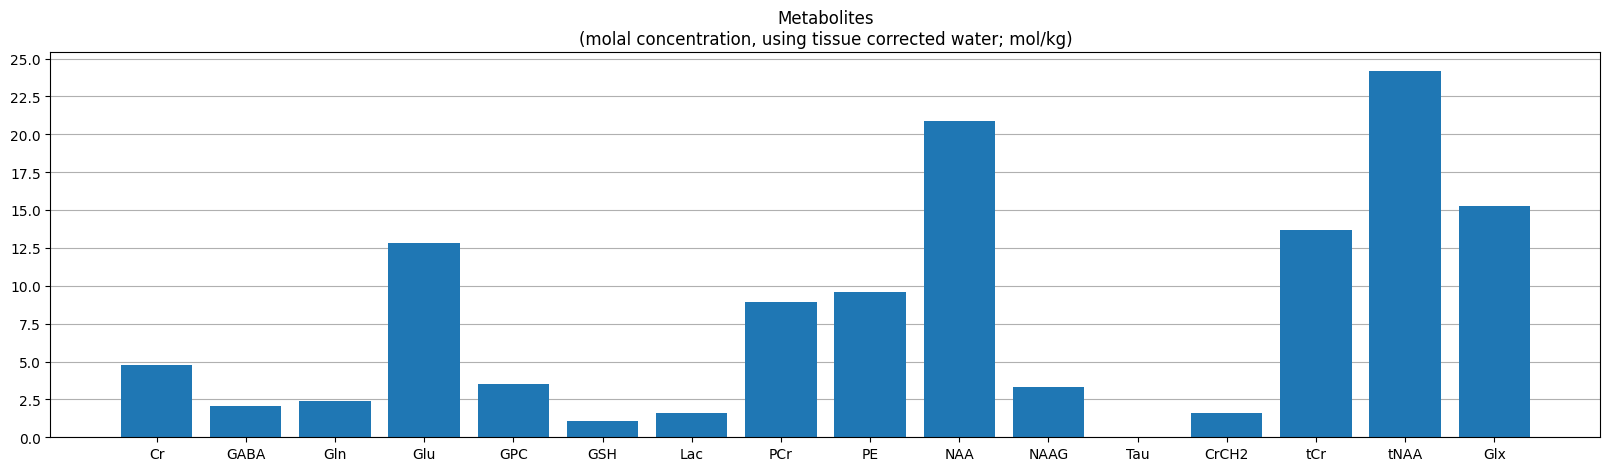

In [16]:
met_data = pd.read_csv(f'{output_path}/QuantifyResults/A_TissCorrWaterScaled_Voxel_1_Basis_1.tsv', delimiter='\t')
plot_metabolites(met_data[metabolites], label='(molal concentration, using tissue corrected water; mol/kg)', ytick_step=2.5)